# 01_EDA: Exploratory Data Analysis

This notebook performs basic exploratory data analysis (EDA) on the Oddbox historical subscription dataset. The goal is to understand the structure, quality, and key trends within the data before modelling.

### Purpose:
- Understand the distribution of box orders across time and box types
- Examine the role of subscriber counts (weekly, fortnightly) in demand
- Explore the impact of holidays and marketing campaigns
- Identify missing values, anomalies, or inconsistencies in the dataset
- Generate initial hypotheses to inform feature engineering and modelling strategy

This notebook is intentionally focused on **foundational insights** — not modelling. The outputs will guide the structure of feature pipelines and highlight areas where assumptions or adjustments may be needed. 

#### 3. Temporal Coverage
 - List or plot number of weeks covered
 - Verify that the data spans ~52 weeks
 - Plot subscriber counts over time (weekly vs fortnightly)

#### 4. Demand Trends by Box Type
 - Line plot of box_orders over time, per box type (facet by box type or use color)
 - Summary stats (mean, median, std, range) per box type
 - Identify high-variance vs low-variance boxes

#### 5. Campaign & Holiday Impact
 - Count of weeks with is_marketing_week, holiday_week
 - Compare average demand in:
   - Marketing vs non-marketing weeks
   - Holiday vs non-holiday weeks

#### 6. Correlation Exploration
 - Correlation between:
   - Weekly subscribers vs total box orders
   - Fortnightly subscribers vs volatility
 - Optional: scatter plots with basic regression lines

#### 7. Hypothesis Formation / Next Steps
 - Markdown cell summarizing:
 - Interesting patterns
 - Feature ideas (e.g. lag features, growth rate of subscribers)
 - Any obvious outliers, anomalies, or cleaning tasks for preprocessing



## 1. Setup & Data Load

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Set default styles for plots
sns.set_context("notebook")
%matplotlib inline

In [9]:
# Load dataset
data_path = "../data/raw/data.csv"
df_raw = pd.read_csv(data_path)

# Basic shape and structure
print("Data shape:", df_raw.shape)
print("\nColumn names:", df_raw.columns.tolist())

# Quick look at data types and nulls
print("\n--------- .info() ---------")
df_raw.info()

# Summary stats
print("\n--------- .describe() ---------")
print(df_raw.describe(include="all"))

# Preview sample rows
df_raw.head()

Data shape: (416, 7)

Column names: ['week', 'box_type', 'box_orders', 'is_marketing_week', 'holiday_week', 'weekly_subscribers', 'fortnightly_subscribers']

--------- .info() ---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   week                     416 non-null    object 
 1   box_type                 416 non-null    object 
 2   box_orders               416 non-null    object 
 3   is_marketing_week        416 non-null    bool   
 4   holiday_week             416 non-null    bool   
 5   weekly_subscribers       416 non-null    int64  
 6   fortnightly_subscribers  415 non-null    float64
dtypes: bool(2), float64(1), int64(1), object(3)
memory usage: 17.2+ KB

--------- .describe() ---------
              week box_type box_orders is_marketing_week holiday_week  \
count          416      416        416        

,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers
0,2024-04-15,LFV,79,False,False,483,167.0
1,2024-04-15,LV,79,False,False,483,167.0
2,2024-04-15,MFV,84,False,False,483,167.0
3,2024-04-15,MV,78,False,False,483,167.0
4,2024-04-15,SFV,82,False,False,483,167.0


Based on the structure and summary of the dataset:

- **Rows and Columns**: 416 rows × 7 columns. This matches 52 weeks × 8 box types, confirming that we have full weekly coverage across all box types.
- **Data Types**:
  - `week`, `box_type`, and `box_orders` are currently stored as **object** types. These should be parsed as:
    - `week`: datetime
    - `box_orders`: numeric (currently object due to likely formatting issues)
  - `fortnightly_subscribers` has one missing value.
- **Boolean Flags**:
  - `is_marketing_week` and `holiday_week` are both boolean and cleanly encoded.
  - Most weeks are **non-marketing** (336 out of 416 rows) and **non-holiday** (376 out of 416), which means special weeks are relatively rare and may require careful treatment to avoid overfitting.
- **Box Types**:
  - 8 distinct `box_type` values are represented equally across weeks — no apparent imbalance.
- **Box Orders**:
  - 59 unique values; most common value is 84.
  - Since it's typed as object, we suspect a non-numeric entry (e.g. a typo such as `"1O0"` instead of `100`) which must be cleaned.
- **Subscribers**:
  - `weekly_subscribers` ranges from 412 to 571 — fairly stable over time.
  - `fortnightly_subscribers` is similar but includes one missing value and floats instead of integers. Likely needs imputation or conversion.


## 2. Data Integrity Checks

In [14]:
df_clean = df_raw.copy()
# 1. Check for missing values
print("Missing Values:\n")
missing_counts = df_clean.isnull().sum()
print(missing_counts)

# Check which row has the missing `fortnightly_subscribers` value
missing_fortnightly = df_clean[df_clean['fortnightly_subscribers'].isnull()]
print("\nRow with missing `fortnightly_subscribers`:")
display(missing_fortnightly)

# 2. Check unique weeks and box type coverage
unique_weeks = df_clean['week'].nunique()
unique_box_types = df_clean['box_type'].nunique()
rows_per_week = df_clean.groupby('week').size()

print(f"\nUnique weeks: {unique_weeks}")
print(f"Unique box types: {unique_box_types}")

# Check if each week has exactly 8 box types
print("\nRows per week (should all be 8):")
print(rows_per_week.value_counts())

# 3. Check for duplicated rows
dupes = df_clean.duplicated()
print(f"\nNumber of duplicate rows: {dupes.sum()}")
if dupes.sum() > 0:
    display(df_clean[df_clean.duplicated()])

# 4. Inspect box_orders for non-numeric values
non_numeric_orders = df_clean[~df_clean['box_orders'].astype(str).str.match(r'^\d+$')]
print(f"\nNon-numeric entries in `box_orders`: {len(non_numeric_orders)}")
if not non_numeric_orders.empty:
    display(non_numeric_orders)

# Manually correct known typo
df_clean['box_orders'] = df_clean['box_orders'].replace("1O0", "100")  # fix typo where 'O' is used
df_clean['box_orders'] = pd.to_numeric(df_clean['box_orders'], errors='coerce')

# Re-check for NaNs in `box_orders` after conversion
print("\nNulls in `box_orders` after conversion:", df_clean['box_orders'].isnull().sum())

Missing Values:

week                       0
box_type                   0
box_orders                 0
is_marketing_week          0
holiday_week               0
weekly_subscribers         0
fortnightly_subscribers    1
dtype: int64

Row with missing `fortnightly_subscribers`:


,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers
68,2024-06-10,SFV,94,False,False,554,NaN



Unique weeks: 52
Unique box types: 8

Rows per week (should all be 8):
8    52
Name: count, dtype: int64

Number of duplicate rows: 0

Non-numeric entries in `box_orders`: 1


,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers
43,2024-05-20,MV,1O0,True,False,510,179.0



Nulls in `box_orders` after conversion: 0


In [15]:
# Fill with average for that week (across other box types)
sfv_week = df_clean[(df_clean["week"] == "2024-06-10") & (df_clean["fortnightly_subscribers"].notnull())]
imputed_value = df_clean[(df_clean["week"] == "2024-06-10")]["fortnightly_subscribers"].median()
df_clean["fortnightly_subscribers"] = df_clean["fortnightly_subscribers"].fillna(imputed_value)

- All 52 weeks are present with 8 unique box types each → temporal structure is clean
- No duplicate rows found
- One non-numeric `box_orders` entry ("1O0") was detected and corrected to 100
- Column `box_orders` has been safely converted to numeric without introducing NaNs
- One missing value in `fortnightly_subscribers` (on 2024-06-10 for box type `SFV`)
  - Imputed using the median subscriber count for that week
- Overall: the dataset is structurally sound and ready for time-based feature engineering and modeling

## 3. Temporal Coverage

Number of unique weeks: 52
Date range: 2024-04-15 to 2025-04-07

Weekly row count stats:
count    52.0
mean      8.0
std       0.0
min       8.0
25%       8.0
50%       8.0
75%       8.0
max       8.0
dtype: float64


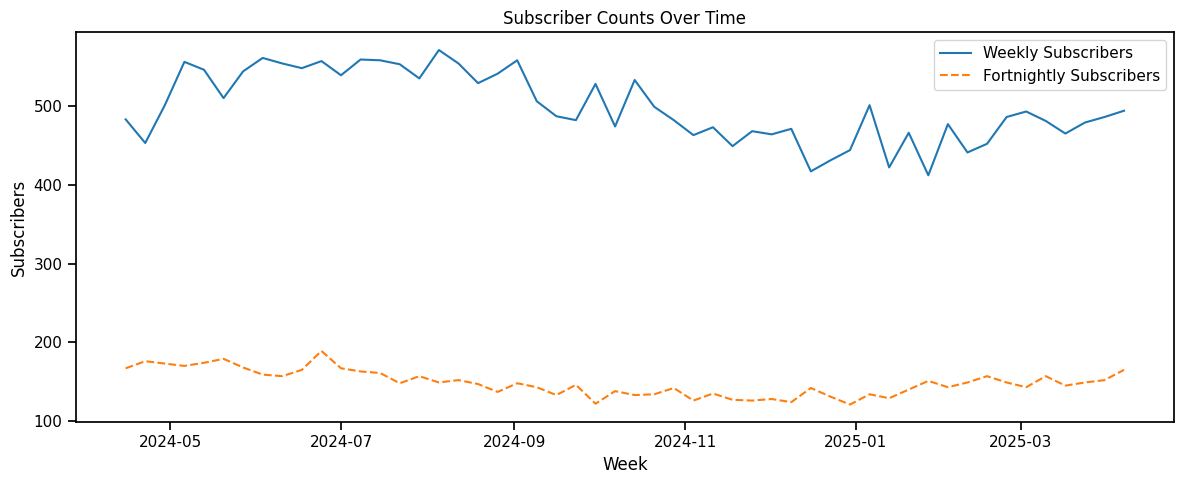

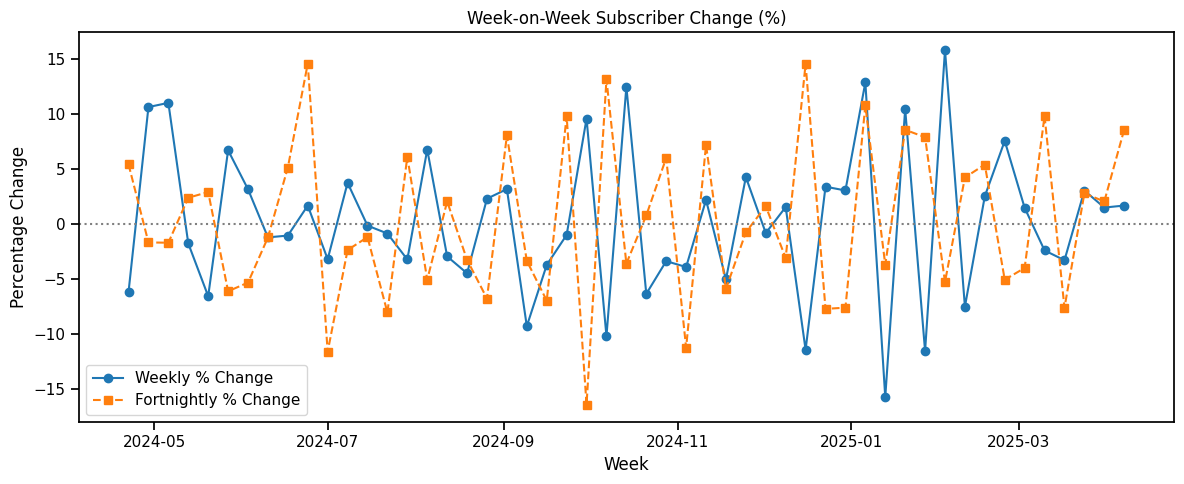

Correlation (Weekly Subs vs. Orders): 0.739
Correlation (Fortnightly Subs vs. Orders): 0.583


In [28]:
# 1. Ensure datetime formatting
df_clean["week"] = pd.to_datetime(df_clean["week"], errors="coerce")

# 2. Validate weekly structure
num_weeks = df_clean["week"].nunique()
min_week = df_clean["week"].min()
max_week = df_clean["week"].max()
weekly_counts = df_clean.groupby("week").size()

print(f"Number of unique weeks: {num_weeks}")
print(f"Date range: {min_week.date()} to {max_week.date()}")
print(f"\nWeekly row count stats:\n{weekly_counts.describe()}")
assert weekly_counts.nunique() == 1 and weekly_counts.iloc[0] == 8, "Not all weeks have 8 box types"

# 3. Aggregate subscriber data to weekly level
weekly_subs = df_clean.groupby("week")[["weekly_subscribers", "fortnightly_subscribers"]].mean().reset_index()

# 4. Compute percentage change to observe volatility
weekly_subs["weekly_subs_pct_change"] = weekly_subs["weekly_subscribers"].pct_change()
weekly_subs["fortnightly_subs_pct_change"] = weekly_subs["fortnightly_subscribers"].pct_change()

# 5. Plot subscriber trends
plt.figure(figsize=(12, 5))
plt.plot(weekly_subs["week"], weekly_subs["weekly_subscribers"], label="Weekly Subscribers", color="tab:blue")
plt.plot(weekly_subs["week"], weekly_subs["fortnightly_subscribers"], label="Fortnightly Subscribers", linestyle="--", color="tab:orange")
plt.title("Subscriber Counts Over Time")
plt.xlabel("Week")
plt.ylabel("Subscribers")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Plot week-on-week percentage change
plt.figure(figsize=(12, 5))
plt.plot(weekly_subs["week"], weekly_subs["weekly_subs_pct_change"] * 100, label="Weekly % Change", marker="o")
plt.plot(weekly_subs["week"], weekly_subs["fortnightly_subs_pct_change"] * 100, label="Fortnightly % Change", marker="s", linestyle="--")
plt.axhline(0, color="grey", linestyle=":")
plt.title("Week-on-Week Subscriber Change (%)")
plt.xlabel("Week")
plt.ylabel("Percentage Change")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Correlation between subscriber counts and total box demand
box_orders_per_week = df_clean.groupby("week")["box_orders"].sum().reset_index(name="total_box_orders")
merged = pd.merge(weekly_subs, box_orders_per_week, on="week")

corr_weekly = merged["weekly_subscribers"].corr(merged["total_box_orders"])
corr_fortnightly = merged["fortnightly_subscribers"].corr(merged["total_box_orders"])
print(f"Correlation (Weekly Subs vs. Orders): {corr_weekly:.3f}")
print(f"Correlation (Fortnightly Subs vs. Orders): {corr_fortnightly:.3f}")

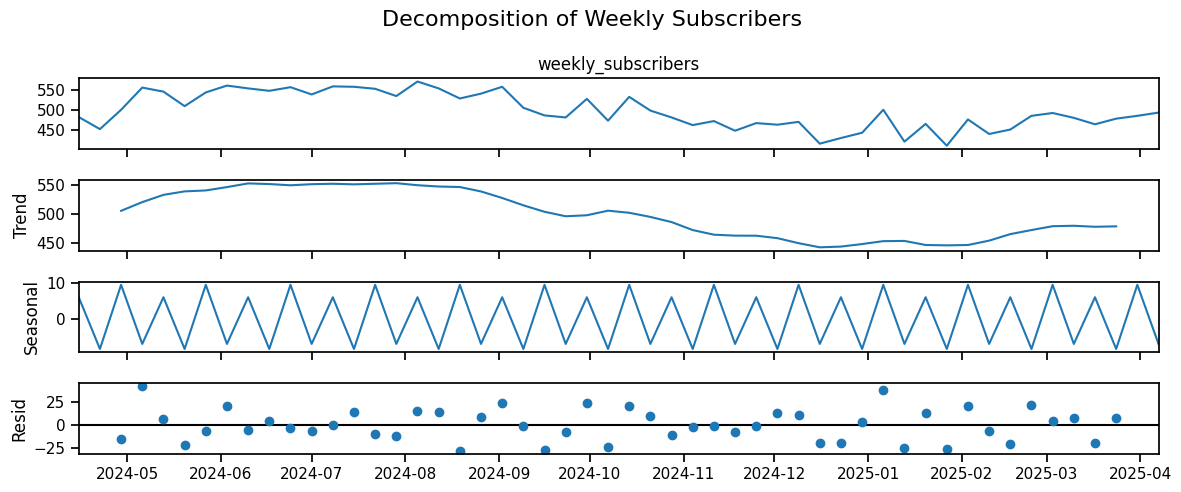

In [35]:
# Decompose weekly subscriber counts into trend, seasonality, and residual components
# Helps assess whether fluctuations are driven by short-term noise, underlying trends, or periodic behavior
weekly_subs_ts = weekly_subs.set_index("week")["weekly_subscribers"]

# Perform decomposition
decomp = seasonal_decompose(weekly_subs_ts, model='additive', period=4)

# Create and size the figure directly from the plot object
fig = decomp.plot()
fig.set_size_inches(12, 5)
fig.suptitle("Decomposition of Weekly Subscribers", fontsize=16)
plt.tight_layout()
plt.show()

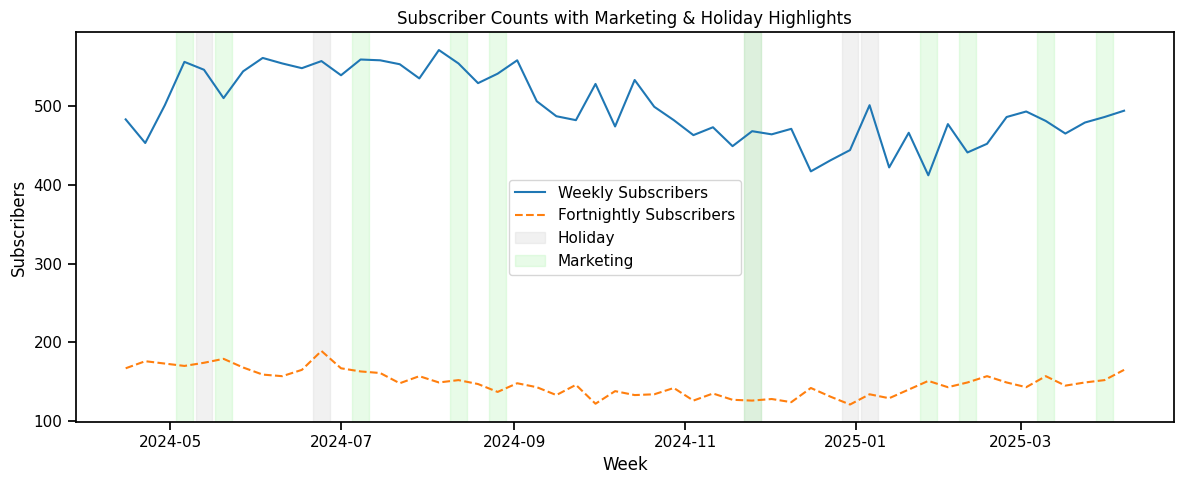

In [ ]:
# Plot subscriber counts over time with holiday and marketing week overlays
event_flags = df_clean.groupby("week")[["holiday_week", "is_marketing_week"]].max().reset_index()
subscribers_with_flags = pd.merge(weekly_subs, event_flags, on="week")

plt.figure(figsize=(12, 5))

# Line plots
plt.plot(subscribers_with_flags["week"], subscribers_with_flags["weekly_subscribers"], label="Weekly Subscribers", color="tab:blue")
plt.plot(subscribers_with_flags["week"], subscribers_with_flags["fortnightly_subscribers"], label="Fortnightly Subscribers", linestyle="--", color="tab:orange")

# Shading holiday weeks
for _, row in subscribers_with_flags[subscribers_with_flags["holiday_week"]].iterrows():
    plt.axvspan(row["week"] - pd.Timedelta(days=3), row["week"] + pd.Timedelta(days=3), color='lightgrey', alpha=0.3)

# Shading marketing weeks
for _, row in subscribers_with_flags[subscribers_with_flags["is_marketing_week"]].iterrows():
    plt.axvspan(row["week"] - pd.Timedelta(days=3), row["week"] + pd.Timedelta(days=3), color='lightgreen', alpha=0.2)

# Create custom legend handles for shaded regions
holiday_patch = mpatches.Patch(color='lightgrey', alpha=0.3, label='Holiday')
marketing_patch = mpatches.Patch(color='lightgreen', alpha=0.2, label='Marketing')

# Add full legend
plt.legend(handles=[
    plt.Line2D([], [], label="Weekly Subscribers", color="tab:blue"),
    plt.Line2D([], [], label="Fortnightly Subscribers", linestyle="--", color="tab:orange"),
    holiday_patch,
    marketing_patch
])

plt.title("Subscriber Counts with Marketing & Holiday Highlights")
plt.xlabel("Week")
plt.ylabel("Subscribers")
plt.tight_layout()
plt.show()


In [ ]:
# Check how subscriber count correlates with box orders at different lags
# Helps determine whether subscriber changes influence box demand immediately (lag=0) or with a delay of 1–2 weeks
for lag in [0, 1, 2]:
    shifted = merged["weekly_subscribers"].shift(lag)
    corr = merged["total_box_orders"].corr(shifted)
    print(f"Correlation at lag {lag} weeks: {corr:.3f}")

Correlation at lag 0 weeks: 0.739
Correlation at lag 1 weeks: 0.659
Correlation at lag 2 weeks: 0.661


##### Temporal Coverage Key Takeaways

- **Date Range & Structure**:
  - Data spans exactly **52 weeks**, from **2024-04-15 to 2025-04-07**, with full weekly coverage (8 box types per week).
  - No missing weeks or structural anomalies detected.

- **Subscriber Trends**:
  - **Weekly subscribers** show a mild rise early in the year, a plateau through summer, and a gradual dip through autumn before partially recovering in Q1 2025.
  - **Fortnightly subscribers** are more stable but trend slightly downward across the year with more noise.

- **Volatility & Churn Signals**:
  - Both subscriber types exhibit **week-on-week percentage fluctuations**, with some weeks showing changes >10%.
  - This suggests meaningful short-term churn/activation patterns, relevant for feature engineering (e.g., lagged deltas).

- **Seasonal Decomposition**:
  - Weekly subscribers exhibit **strong weekly seasonality** and a noticeable **downward trend** in late 2024.
  - The residual (noise) appears well-behaved — no major anomalies.

- **Event Overlay (Marketing & Holidays)**:
  - Subscriber counts show visible spikes aligned with **marketing campaigns**, supporting the case for modeling campaign effects explicitly.
  - Holiday periods often coincide with **flat or reduced subscriber growth**, particularly during late December and early January.

- **Correlation with Demand**:
  - Weekly subscriber count has a strong positive correlation with total box orders (**r = 0.739**).
  - Fortnightly subscribers are also correlated (**r = 0.583**), though less tightly.
  - **Lag analysis** shows that box orders are most strongly aligned with **current-week subscriber counts** (lag 0), but lag-1 and lag-2 remain meaningfully correlated (r ≈ 0.66), justifying the inclusion of lagged features.

### Implication for Modeling
- Subscriber count is a **key predictor** of demand, especially weekly subscribers.
- Event weeks (marketing, holidays) must be modeled as exogenous effects.
- Lagged subscriber values may help stabilize noisy box-level forecasts.